## RNN (RAVDESS data)

Wei Li

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time
import random
import soundfile
import librosa


# random_seed = 123
# os.environ["PL_GLOBAL_SEED"] = str(random_seed)
# random.seed(random_seed)
# np.random.seed(random_seed)

In [2]:
# %pip install watermark
%load_ext watermark
%watermark -a "Wei Li" -u -t -d -v -p numpy,torch,soundfile,librosa

Author: Wei Li

Last updated: 2023-12-29 15:06:19

Python implementation: CPython
Python version       : 3.8.17
IPython version      : 8.12.2

numpy    : 1.21.5
torch    : 1.12.1
soundfile: 0.12.1
librosa  : 0.10.1



In [3]:
# From local helper files
from utils_evaluation import (
    set_all_seeds,
    set_deterministic,
    evaluate_epoch_loss,
    evaluate_epoch_metrics,
    get_predictions,
)
from utils_plotting import plot_accuracy, plot_loss, plot_confusion_matrix
from utils_data import get_np_ravdess2

In [4]:
## Setting 
RANDOM_SEED = 2022
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
set_all_seeds(RANDOM_SEED)
set_deterministic()

In [5]:
## RAVDESS Emotional speech audio
## https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
## Speech audio-only files (16bit, 48kHz .wav) from the RAVDESS.
##
## This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440.
## The RAVDESS contains 24 professional actors (12 female, 12 male),
## vocalizing two lexically-matched statements in a neutral North American accent.
## Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions.
## Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

# The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

# Filename identifiers:
# Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
# Vocal channel (01 = speech, 02 = song).
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
# Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
# Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
# Repetition (01 = 1st repetition, 02 = 2nd repetition).
# Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
# Filename example: 03-01-06-01-02-01-12.wav

# Emotions in the RAVDESS dataset
# emotions = {
#     "01": "neutral",
#     "02": "calm",
#     "03": "happy",
#     "04": "sad",
#     "05": "angry",
#     "06": "fearful",
#     "07": "disgust",
#     "08": "surprised",
# }

In [6]:
# subset of emotions under consideration
# emotions_labels = ["calm", "happy", "fearful", "disgust"]
emotions_labels = [
    "neutral",
    "calm",
    "happy",
    "sad",
    "angry",
    "fearful",
    "disgust",
    "surprised",
]


###############################################
#### -----  check on one example -------- ####
###############################################

example, sr = librosa.load(
    "/Users/wli169/Documents/Work/datasets/RAVDESS-speech/Actor_01/03-01-01-01-01-01-01.wav",
    sr=48000,  # default resampling rate sr=22050
)
# WL: an alternative way to load is to use soundfile.SoundFile()
# however,there is some file cannot be properly loaded,
# e.g. /Actor_20/03-01-06-01-01-02-20.wav
# as the duration got truncated

librosa.get_duration(y=example, sr=48000)

type(example), example.shape
# np.ndarray shape: (158558,) where 48000*1*3.3 secs
# mono (1 channel)

librosa.feature.mfcc(
    y=example, sr=48000, n_mfcc=10
).shape  # (n_mfcc, t=num_frames)=(10, 310), default n_mfcc=10

stft = librosa.stft(example)
librosa.feature.chroma_stft(S=stft, sr=48000, n_chroma=12).shape  #  default n_chroma=12

librosa.feature.melspectrogram(
    y=example, sr=48000, n_mels=128
).shape  # default (n_mels=128, num_frames)

(128, 310)

In [7]:
stft = librosa.stft(example)
ch1 = librosa.feature.chroma_stft(S=stft, sr=48000, n_chroma=12)

mc1 = librosa.feature.mfcc(y=example, sr=48000, n_mfcc=10)

ch1.shape, mc1.shape

result = np.vstack((mc1, ch1))
result.shape

(22, 310)

In [8]:
######################################
#### -----  load data -------- ####
### We set chroma=False, mel=False
######################################


# This function extracts audio features from a sound file
def extract_feature2(file_name, mfcc, chroma, mel):
    # Open the sound file using 'librosa' library and read samples into variable 'X'
    X, sample_rate = librosa.load(file_name, sr=48000, dtype="float32")
    # If chroma is true, calculate short-time Fourier transform of X
    if chroma:
        stft = np.abs(librosa.stft(X))
    if mfcc:
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=10).T
        # mfccs: shape (num_frames, n_mfcc)
        result = mfccs
    if chroma:
        chroma = (librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=12).T,)
        result = np.vstack((result, chroma))
    if mel:
        mel = (librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128).T,)
        result = np.vstack((result, mel))
    # Return the resulting numpy array containing extracted features

    # shape (num_frames, n_mfcc + n_crhoma + n_mel)
    return result


### We set chroma=False, mel=False

example_feature = extract_feature2(
    "/Users/wli169/Documents/Work/datasets/RAVDESS-speech/Actor_01/03-01-01-01-01-01-01.wav",
    mfcc=True,
    chroma=False,
    mel=False,
)
# shape (num_frames, num_mfccs)
example_feature.shape

(310, 10)

In [9]:
# load np_ravdess numpy data
x_dat, y_dat = get_np_ravdess2(
    emotions_labels, extract_feature2, max_frames=310, chroma_T=False, mel_T=False
)
x_dat.shape, y_dat.shape

x_train, x_test, y_train, y_test = train_test_split(
    x_dat, y_dat, test_size=0.2, random_state=2023, stratify=y_dat
)
x_train.shape, x_test.shape
# since we have a small dataset, we just use validation data as test data
# stratify=y_dat: each category is roughly equally represented in training and test data

# Get the shape of the training and testing datasets
print((x_train.shape, x_test.shape))
# (num_examples, num_frames, num_features)
# ((1152, 310, 10), (288, 310, 10))
print((y_train.shape, y_test.shape))
# ((1152,), (288,))

((1152, 310, 10), (288, 310, 10))
((1152,), (288,))


In [10]:
# Creating the dictionary mapping
emotions_dict = {i: emotion for i, emotion in enumerate(emotions_labels)}
# {
#     0: "neutral",
#     1: "calm",
#     2: "happy",
#     3: "sad",
#     4: "angry",
#     5: "fearful",
#     6: "disgust",
#     7: "surprised",
# }

# Function to convert labels from string to numeric
def convert_labels(y, mapping):
    return np.array([mapping.index(label) for label in y])

# Assuming y_train and y_test are arrays of strings like ['happy', 'sad', ...]
y_train_numeric = convert_labels(y_train, emotions_labels)
y_test_numeric = convert_labels(y_test, emotions_labels)

In [11]:
# StandardScaler is typically used on 2D data (samples x features).
# Since your data is 3D (num_examples, num_frames, num_features), you'll need to
# reshape it to 2D, apply the scaler, and then reshape it back to 3D.

def standardize_with_scaler(x_train, x_test):
    # Reshape the data to 2D (samples * time frames, features)
    num_examples, num_frames, num_features = x_train.shape
    x_train_reshaped = x_train.reshape(-1, num_features)
    x_test_reshaped = x_test.reshape(-1, num_features)

    # Create a StandardScaler object and fit it to the training data
    scaler = StandardScaler().fit(x_train_reshaped)

    # Extract mean and variance
    mean = scaler.mean_
    variance = scaler.var_

    # Apply the scaler to both training and testing data
    x_train_standardized = scaler.transform(x_train_reshaped).reshape(
        num_examples, num_frames, num_features
    )
    x_test_standardized = scaler.transform(x_test_reshaped).reshape(x_test.shape)

    return x_train_standardized, x_test_standardized, mean, variance


# Apply standardization and get mean and variance
x_train_standardized, x_test_standardized, mean, variance = standardize_with_scaler(
    x_train, x_test
)
# mean.shape, variance.shape
# (10,), (10,)

In [12]:
# Define the custom Dataset class
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy array): Standardized features
            y (numpy array): Numeric labels
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Assuming x_train_standardized, y_train_numeric, x_test_standardized, y_test_numeric are defined
train_data = EmotionDataset(x_train_standardized, y_train_numeric)
test_data = EmotionDataset(x_test_standardized, y_test_numeric)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [13]:
print("No. of train examples  : ", train_data.__len__())
print("Shape of example       : ", train_data[0][0].shape)
print("No. of test examples  : ", test_data.__len__())
print("Train batches        : ", train_loader.__len__())
print("Test batches        : ", test_loader.__len__())

No. of train examples  :  1152
Shape of example       :  torch.Size([310, 10])
No. of test examples  :  288
Train batches        :  9
Test batches        :  3


### Simple RNN


In [14]:
class SimpleRNNModel(nn.Module):
    """
    A simple RNN model with two RNN layers followed by a linear layer.

    #                       (output :logits)
    # layer 2                    Linear
    # layer 1    RNN  --- RNN --- RNN
    # layer 0    RNN  --- RNN --- RNN
    #            time0---time1---time2

    The RNN layers process the input sequence, and the linear layer is
    applied to the output of the last time step of the sequence to produce
    logits for classification.

    Attributes:
        rnn (nn.RNN): The RNN module, which contains two RNN layers.
        linear (nn.Linear): A linear layer to transform the output of the
                            RNN at the last time step into logits.

    Args:
        input_size (int): The number of features in the input data.
        hidden_size (int): The size of the hidden state in the RNN layers.
        output_size (int): The number of output classes (the size of the output layer).
        num_layers (int, optional): The number of stacked RNN layers. Default is 2.
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(SimpleRNNModel, self).__init__()

        # Initialize the RNN layers. 'batch_first=True' indicates that the
        # input tensors will have a shape of (batch_size, seq_len, input_size)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Initialize the linear layer that will transform the hidden state
        # output at the last time step into the output logits.
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): The input tensor with shape
                              (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: The output logits tensor with shape
                          (batch_size, output_size).
        """
        # Forward pass through the RNN layers.
        # The output tensor shape will be (batch_size, seq_len, hidden_size)
        output, _ = self.rnn(x)

        # Extract the output of the RNN at the last time step.
        # This is equivalent to selecting the output at the final time step
        # for each sequence in the batch.
        last_time_step_output = output[:, -1, :]

        # Pass the output of the last time step through the linear layer
        # to obtain the logits for each class.
        logits = self.linear(last_time_step_output)

        return logits

In [15]:
# Hyperparameters
LR = 1e-3  # Learning rate
NUM_EPOCHS = 200  # Number of training epochs
HIDDEN_SIZE = 32  # Number of features in the hidden state of the RNN
INPUT_SIZE = 10  # Number of input features (e.g., num_features)
OUTPUT_SIZE = len(
    emotions_labels
)  # Number of output classes (size of your emotions labels list)

# Initialize the model
model = SimpleRNNModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# StepLR decreases the learning rate by a factor of gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [16]:
start_time = time.time()
(
    minibatch_loss_list,
    avg_loss_list,
    train_loss_list,
    val_loss_list,
    train_acc_list,
    val_acc_list,
) = ([], [], [], [], [], [])

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)

        # ## FORWARD AND BACK PROP
        y_pred = model(features)
        loss = criterion(y_pred, targets)
        optimizer.zero_grad()

        loss.backward()

        # ## UPDATE MODEL PARAMETERS
        optimizer.step()

        step_len = float(optimizer.param_groups[0]["lr"])

        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 5:
            print(
                f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
                f"| Batch {batch_idx:04d}/{len(train_loader):04d} "
                f"| Loss: {loss:.4f}"
                f"| Step len: {step_len:.6f}"
            )

    model.eval()
    with torch.no_grad():  # save memory during inference
        ### logging for running average of loss over all traversed minibatches
        # avg_loss = torch.mean(torch.FloatTensor(minibatch_loss_list))
        # or the average over most recent minibatches in last epoch
        avg_loss = torch.mean(
            torch.FloatTensor(minibatch_loss_list[-len(train_loader) :])
        )
        avg_loss_list.append(avg_loss)

        train_loss = evaluate_epoch_loss(
            model, train_loader, device=device, criterion=nn.CrossEntropyLoss()
        )[1]
        val_loss = evaluate_epoch_loss(
            model, test_loader, device=device, criterion=nn.CrossEntropyLoss()
        )[1]

        train_acc = evaluate_epoch_metrics(model, train_loader, device=device)
        val_acc = evaluate_epoch_metrics(model, test_loader, device=device)

        # Print train and test loss along with accuracy
        print(
            f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
            f"| Train Loss: {train_loss:.4f} "
            f"| Test Loss: {val_loss:.4f} "
            f"| Train Acc: {train_acc:.2f}% "
            f"| Test Acc: {val_acc:.2f}% "
        )

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

    # Update learning rate scheduler
    scheduler.step()

    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
print(f"Total Training Time: {elapsed:.2f} min")

print()
test_acc = evaluate_epoch_metrics(model, test_loader, device=device)
print(f"Test accuracy {test_acc :.2f}")

Epoch: 001/200 | Batch 0000/0009 | Loss: 2.1437| Step len: 0.001000
Epoch: 001/200 | Batch 0005/0009 | Loss: 2.1061| Step len: 0.001000
Epoch: 001/200 | Train Loss: 2.0625 | Test Loss: 2.0680 | Train Acc: 15.97% | Test Acc: 14.58% 
Time elapsed: 0.02 min
Epoch: 002/200 | Batch 0000/0009 | Loss: 2.0802| Step len: 0.001000
Epoch: 002/200 | Batch 0005/0009 | Loss: 2.0323| Step len: 0.001000
Epoch: 002/200 | Train Loss: 2.0326 | Test Loss: 2.0428 | Train Acc: 21.70% | Test Acc: 22.92% 
Time elapsed: 0.03 min
Epoch: 003/200 | Batch 0000/0009 | Loss: 2.0303| Step len: 0.001000
Epoch: 003/200 | Batch 0005/0009 | Loss: 2.0510| Step len: 0.001000
Epoch: 003/200 | Train Loss: 1.9982 | Test Loss: 2.0131 | Train Acc: 27.00% | Test Acc: 24.31% 
Time elapsed: 0.05 min
Epoch: 004/200 | Batch 0000/0009 | Loss: 2.0204| Step len: 0.001000
Epoch: 004/200 | Batch 0005/0009 | Loss: 1.9422| Step len: 0.001000
Epoch: 004/200 | Train Loss: 1.9357 | Test Loss: 1.9541 | Train Acc: 27.78% | Test Acc: 28.47% 
Tim

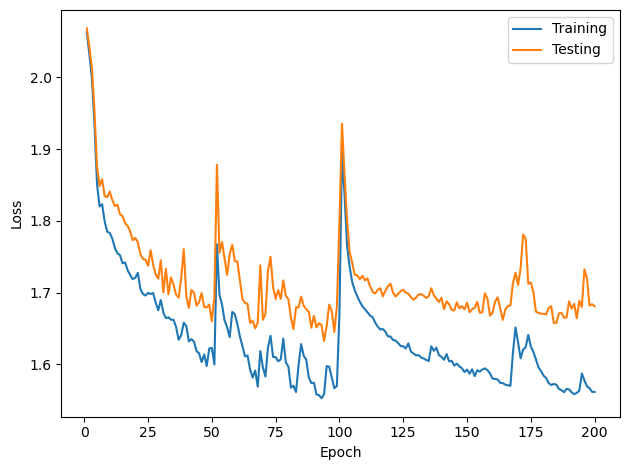

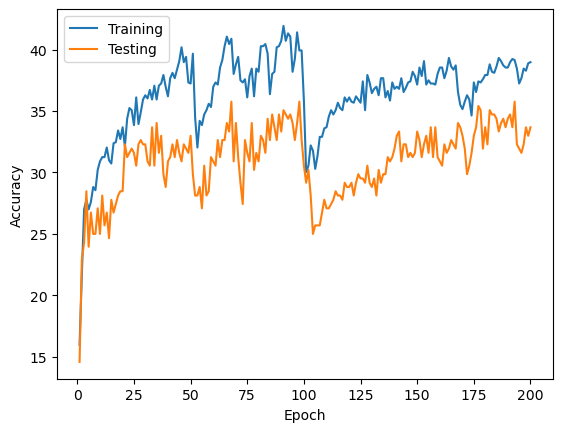

In [17]:
# Evaluation
plot_loss(
    train_loss_list=train_loss_list, valid_loss_list=val_loss_list, results_dir=None
)
plt.show()

plot_accuracy(
    train_acc_list=train_acc_list, valid_acc_list=val_acc_list, results_dir=None
)
plt.show()

# test accuracy rate 33.68, not impressive, yet this model serves as a comparison for 
# the numpy implementation of RNN model

#### confusion matrix

In [18]:
# Get predictions
test_x, test_y, test_predictions = get_predictions(model, test_loader, device)

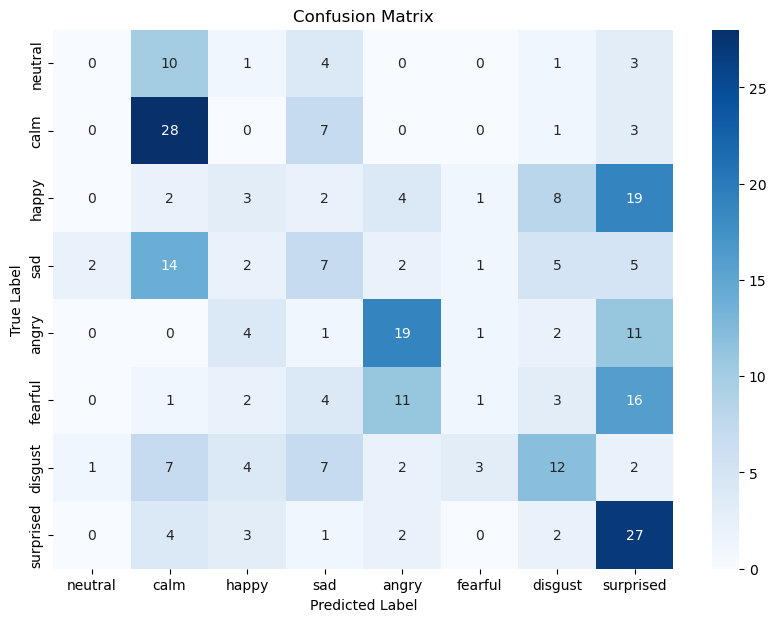

In [19]:
plot_confusion_matrix(test_y, test_predictions, emotions_dict)